<a href="https://colab.research.google.com/github/ChristineLwin/churn_prediction/blob/main/Churn%20Prediction%20using%20ML%20algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('churn-prediction-using-linear-nonlinear-and-ensemble-algorithms')
jovian.set_colab_id('1SEGIBYzA6bgeGYlsIk-1jmXB1Xb7LTqc')

### Churn Prediction using linear, nonlinear & ensemble algorithms
* EDA 
* Preprocessing - Cleaning and Transformation
    * Encoding
    * Scaling 
    * Dealing with imbalanced data using synthetic minority oversampling technique, SMOTE 
* Prediction using ML algorithms 
    * Linear Algos
        1. Naive Bayes
        2. Logistic Regression
    * Nonlinear Algos
        3. NN
        4. K Nearest Neighbour
        5. Support Vector Classifier
        6. Decision Tree Classifier
    * Ensemble Algos
        * Bagging Approach
          7. Random Forest Classifier 
        * Boosting Approach
          8. AdaBoost Classifier 
          9. CatBoost Classifier 
          10. Stochastic Gradient Boosting
          11. XGBoost Classifier

In [2]:
!pip install jovian --upgrade --quiet
!pip install statsmodels --quiet
!pip install opendatasets --upgrade --quiet
!pip install catboost --quiet

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [3]:
import opendatasets as od
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [4]:
od.download('https://www.kaggle.com/blastchar/telco-customer-churn')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: christinelwin
Your Kaggle Key: ··········


100%|██████████| 172k/172k [00:00<00:00, 21.4MB/s]

In [5]:
filepath = './telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [6]:
df = pd.read_csv(filepath)
print(df.shape)
df.sample(3)

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5784,7401-RUBNK,Female,0,Yes,No,18,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Electronic check,74.80,1438.05,No
6327,3736-BLEPA,Male,0,No,No,28,Yes,No,Fiber optic,No,Yes,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),91.25,2483.65,No
1633,1478-VPOAD,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,43.80,43.8,No


In [7]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### Preprocessing and Cleaning

TotalCharges type is string object.  Convert it to float type.  

In [9]:
print(df['TotalCharges'].dtype)
print(df.TotalCharges.values)

object
['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']


#### Missing values

There are 11 records with missing values(empty string) in TotalCharges column.  Since it is only a small proportion (0.15% of the dataset), those records are dropped.

In [10]:
print('No. of records with empty string: ',df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()].shape[0])

#index of the TotalCharges with missing values
idxlst = list(df[pd.to_numeric(df.TotalCharges,errors='coerce').isnull()].index)
# below results show that totalcharges columns have empty string
df.loc[idxlst,['tenure','MonthlyCharges','TotalCharges','Churn']]

No. of records with empty string:  11


,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,,No
753,0,20.25,,No
936,0,80.85,,No
1082,0,25.75,,No
1340,0,56.05,,No
3331,0,19.85,,No
3826,0,25.35,,No
4380,0,20.00,,No
5218,0,19.70,,No
6670,0,73.35,,No


All missing records are also customers with No churn as well as with Zero tenure. As there are significant samples for No Churn (majority class), these 11 missing records/rows are dropped. Customer ID column/feature is also dropped.  

In [11]:
#drop the missing records/rows
df1 = df.drop(idxlst,axis=0)
#drop customerID column
df1 = df1.drop('customerID',axis=1)
df1.shape

(7032, 20)

In [12]:
#convert from string object to float64
df1 = df1.astype({'TotalCharges':np.float64})
df1.TotalCharges.dtypes

dtype('float64')

Statistics of the numeric features - dataset contains tenure range from 1 to 72 and montlycharges rage from 18 to 118. 

In [13]:
df1.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


#### Preprocessing and Data Transformation 
Tranform categorical data to numerical data.  

In [14]:
telcom_df = df1.copy()
telcom_df.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1460,Male,0,No,No,5,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,No,Month-to-month,Yes,Electronic check,85.30,424.15,Yes
6150,Male,0,No,No,32,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Electronic check,91.05,2871.50,No
602,Female,0,Yes,Yes,66,Yes,Yes,Fiber optic,No,No,No,No,No,No,One year,Yes,Bank transfer (automatic),74.25,4859.25,No


In [15]:
# unique values of categorical features
def print_unique_cols(df):
    for col in df.columns:
        if df[col].dtypes=='O':
            print(f'{col} = {df[col].unique()}')

In [16]:
print_unique_cols(telcom_df)

gender = ['Female' 'Male']
Partner = ['Yes' 'No']
Dependents = ['No' 'Yes']
PhoneService = ['No' 'Yes']
MultipleLines = ['No phone service' 'No' 'Yes']
InternetService = ['DSL' 'Fiber optic' 'No']
OnlineSecurity = ['No' 'Yes' 'No internet service']
OnlineBackup = ['Yes' 'No' 'No internet service']
DeviceProtection = ['No' 'Yes' 'No internet service']
TechSupport = ['No' 'Yes' 'No internet service']
StreamingTV = ['No' 'Yes' 'No internet service']
StreamingMovies = ['No' 'Yes' 'No internet service']
Contract = ['Month-to-month' 'One year' 'Two year']
PaperlessBilling = ['Yes' 'No']
PaymentMethod = ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn = ['No' 'Yes']


## Encoding

#### Convert binary features to 0 and 1.     Female = 0, Male = 1;  No = 0, Yes = 1;

In [17]:
telcom_df.gender.replace({'Female':0,'Male':1},inplace=True)
bicols = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']
for c in bicols:
    telcom_df[c].replace({'Yes':1,'No':0}, inplace= True)

In [18]:
for c in telcom_df.columns:
    print(f'{c} = {telcom_df[c].unique()}')

gender = [0 1]
SeniorCitizen = [0 1]
Partner = [1 0]
Dependents = [0 1]
tenure = [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService = [0 1]
MultipleLines = ['No phone service' 'No' 'Yes']
InternetService = ['DSL' 'Fiber optic' 'No']
OnlineSecurity = ['No' 'Yes' 'No internet service']
OnlineBackup = ['Yes' 'No' 'No internet service']
DeviceProtection = ['No' 'Yes' 'No internet service']
TechSupport = ['No' 'Yes' 'No internet service']
StreamingTV = ['No' 'Yes' 'No internet service']
StreamingMovies = ['No' 'Yes' 'No internet service']
Contract = ['Month-to-month' 'One year' 'Two year']
PaperlessBilling = [1 0]
PaymentMethod = ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges = [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges = [  29.85 1889.5   10

#### Convert multi-categorical feature to one hot encoding.  

In [19]:
print_unique_cols(telcom_df)

MultipleLines = ['No phone service' 'No' 'Yes']
InternetService = ['DSL' 'Fiber optic' 'No']
OnlineSecurity = ['No' 'Yes' 'No internet service']
OnlineBackup = ['Yes' 'No' 'No internet service']
DeviceProtection = ['No' 'Yes' 'No internet service']
TechSupport = ['No' 'Yes' 'No internet service']
StreamingTV = ['No' 'Yes' 'No internet service']
StreamingMovies = ['No' 'Yes' 'No internet service']
Contract = ['Month-to-month' 'One year' 'Two year']
PaymentMethod = ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [20]:
cat_col = ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
           'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
           'Contract','PaymentMethod']
telcom_df = pd.get_dummies(data=telcom_df,columns=cat_col,drop_first=True)
telcom_df.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4421,1,0,1,0,34,1,0,88.85,3000.25,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
5466,1,0,0,1,10,1,1,19.95,219.50,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0
1035,1,0,0,0,66,1,0,25.10,1697.70,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1


In [21]:
telcom_df.nunique()

gender                                      2
SeniorCitizen                               2
Partner                                     2
Dependents                                  2
tenure                                     72
PhoneService                                2
PaperlessBilling                            2
MonthlyCharges                           1584
TotalCharges                             6530
Churn                                       2
MultipleLines_No phone service              2
MultipleLines_Yes                           2
InternetService_Fiber optic                 2
InternetService_No                          2
OnlineSecurity_No internet service          2
OnlineSecurity_Yes                          2
OnlineBackup_No internet service            2
OnlineBackup_Yes                            2
DeviceProtection_No internet service        2
DeviceProtection_Yes                        2
TechSupport_No internet service             2
TechSupport_Yes                   

#### Scale numeric features to range between 0 and 1.  

In [22]:
scale_col = ['tenure','MonthlyCharges','TotalCharges']

sc = MinMaxScaler()
telcom_df[scale_col]= sc.fit_transform(telcom_df[scale_col])
telcom_df.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5098,1,1,0,0,0.028169,1,1,0.584577,0.025265,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4866,0,0,0,0,0.211268,1,1,0.445771,0.120961,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
133,1,0,0,0,0.000000,0,1,0.171144,0.001921,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


#### Split data to training and test set.  

In [23]:
# Assign input features to X and output to y.   
X = telcom_df.drop(columns=['Churn'])
y = telcom_df['Churn']

In [24]:
# Split dataset into training and test sets. 
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2,stratify=y,random_state=5)

In [25]:
print(f'training set: {train_X.shape} \n {train_y.value_counts()}')
print('-'*20)
print(f'test set: {test_X.shape} \n {test_y.value_counts()}')

training set: (5625, 30) 
 0    4130
1    1495
Name: Churn, dtype: int64
--------------------
test set: (1407, 30) 
 0    1033
1     374
Name: Churn, dtype: int64


### Upsampling method (SMOTE)

When dealing with an imbalanced dataset, Synthetic Minority Oversampling TEchnique (SMOTE) method can be used to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model. In SMOTE new instances are synthesized from the existing data. It randomly selects a point from the minority class and computes the k-nearest neighbors for this point. The synthetic points are then added between the chosen point and its neighbors.



In [26]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
train_X_re, train_y_re = sm.fit_resample(train_X, train_y)

print('resampled class distribution\n',train_y_re.value_counts())

resampled class distribution
 1    4130
0    4130
Name: Churn, dtype: int64


### Evaluation: Confustion Matrix & Classification Report 

Confusion Matrix shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many class 0 are predicted correctly, and the second row, second column, indicates how many class 1 are predicted correctly.  Therefore, the higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

A Classification report is used to measure the performance of the classifier prediction.  It shows the main classification metrics precision, recall and f1-score on a per-class basis. F1-score calculates the harmonic mean of the precision and recall.


In [27]:
def test_eval(clf_model, testX, testy):
    # Test set prediction
    y_pred=clf_model.predict(testX)
    y_predict = []
    for p in y_pred:
        if p > 0.5:
            y_predict.append(1)
        else:
            y_predict.append(0)
    print('Confusion Matrix')
    print('='*20)
    cm = confusion_matrix(testy,y_predict)
    print(cm,"\n")
    print('Classification Report')
    print('='*20)
    print(classification_report(testy,y_predict))
    cr = classification_report(testy,y_predict,output_dict=True)
    score = roc_auc_score(testy, y_pred)

    return cm,cr,score,y_predict

In [28]:
def plot_cmatrix(cmatrix, name):
    fig = px.imshow(cmatrix,color_continuous_scale=[[0.0, 'peachpuff'], 
                                          [0.5, 'lime'], 
                                          [1.0, 'green']])

    fig.update_layout(
        title = 'Confusion Matrix ('+name+')', title_x=0.5,
        xaxis_title="Prediction", yaxis_title="Truth", 
        height=400,
        width=400,
        xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1),
        yaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1)
    )
    for i in range(len(cmatrix)):
        for j in range(len(cmatrix[0])):
            fig.add_annotation(
                x=j,
                y=i,
                text=str(cmatrix[i,j]),
                showarrow=False,
                font_size=12, font_color='black'
            )

    fig.show()

## Linear Algorithms

#### Churn Prediction using Logistic Regression

In [29]:
para_lr = {'C': [5,10,20], "max_iter":[200,400]} 

model_lr = GridSearchCV(estimator = LogisticRegression(),
                    param_grid = para_lr,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )
model_lr.fit(train_X_re,train_y_re)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [5, 10, 20], 'max_iter': [200, 400]})

In [30]:
model_lr.best_params_

{'C': 20, 'max_iter': 200}

In [31]:
cm_lr,cr_lr,auc_score_lr,_  = test_eval(model_lr,test_X,test_y)
fpr_lr, tpr_lr, thresh_lr = roc_curve(test_y, model_lr.predict_proba(test_X)[:,1], pos_label = 1)
precision_lr, recall_lr, _ = precision_recall_curve(test_y, model_lr.predict_proba(test_X)[:,1], pos_label=1)

Confusion Matrix
[[803 230]
 [ 93 281]] 

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1033
           1       0.55      0.75      0.64       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407



In [32]:
plot_cmatrix(cm_lr, name='LR')

#### Churn Prediction using Naive Bayes

In [33]:
para_gnb = {'var_smoothing':np.logspace(1,-4,num=50)}

model_gnb = GridSearchCV(estimator = GaussianNB(),
                    param_grid = para_gnb,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )
model_gnb.fit(train_X_re,train_y_re)

GridSearchCV(cv=10, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+01, 7.90604321e+00, 6.25055193e+00, 4.94171336e+00,
       3.90693994e+00, 3.08884360e+00, 2.44205309e+00, 1.93069773e+00,
       1.52641797e+00, 1.20679264e+00, 9.54095476e-01, 7.54312006e-01,
       5.96362332e-01, 4.71486636e-01, 3.72759372e-01, 2.94705170e-01,
       2.32995181e-01, 1.842069...
       3.55648031e-02, 2.81176870e-02, 2.22299648e-02, 1.75751062e-02,
       1.38949549e-02, 1.09854114e-02, 8.68511374e-03, 6.86648845e-03,
       5.42867544e-03, 4.29193426e-03, 3.39322177e-03, 2.68269580e-03,
       2.12095089e-03, 1.67683294e-03, 1.32571137e-03, 1.04811313e-03,
       8.28642773e-04, 6.55128557e-04, 5.17947468e-04, 4.09491506e-04,
       3.23745754e-04, 2.55954792e-04, 2.02358965e-04, 1.59985872e-04,
       1.26485522e-04, 1.00000000e-04])})

In [34]:
model_gnb.best_params_

{'var_smoothing': 0.0021209508879201904}

In [35]:
cm_gnb,cr_gnb,auc_score_gnb,_  = test_eval(model_gnb,test_X,test_y)
fpr_gnb, tpr_gnb, thresh_gnb = roc_curve(test_y, model_gnb.predict_proba(test_X)[:,1], pos_label = 1)
precision_gnb, recall_gnb, _ = precision_recall_curve(test_y, model_gnb.predict_proba(test_X)[:,1],pos_label=1)

Confusion Matrix
[[658 375]
 [ 57 317]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.64      0.75      1033
           1       0.46      0.85      0.59       374

    accuracy                           0.69      1407
   macro avg       0.69      0.74      0.67      1407
weighted avg       0.80      0.69      0.71      1407



In [36]:
plot_cmatrix(cm_gnb, name='GNB')

## Nonlinear Algorithms

#### Churn Prediction using ANN with tensorflow, keras

In [37]:
model_nn = Sequential()
model_nn.add(Dense(10,input_shape=(30,),activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                310       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [38]:
model_nn.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')

history_nn = model_nn.fit(train_X_re,train_y_re,
                          validation_split=0.2,
                          epochs=10,
                          verbose=0
                         )

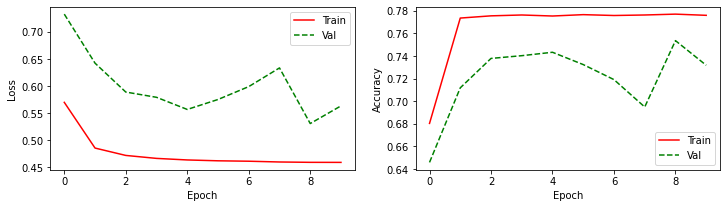

In [39]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(12,3))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(1,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='red', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color='green', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()


plot_metrics(history_nn)

In [40]:
model_nn.evaluate(test_X,test_y)

44/44 [==============================] - 0s 1ms/step - loss: 0.4277 - accuracy: 0.7889


[0.427734375, 0.7889125943183899]

In [41]:
cm_nn,cr_nn,auc_score_nn,_  = test_eval(model_nn,test_X,test_y)
fpr_nn, tpr_nn, thresh_nn = roc_curve(test_y, model_nn.predict(test_X), pos_label = 1)
precision_nn, recall_nn, _ = precision_recall_curve(test_y, model_nn.predict(test_X))

Confusion Matrix
[[865 168]
 [129 245]] 

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1033
           1       0.59      0.66      0.62       374

    accuracy                           0.79      1407
   macro avg       0.73      0.75      0.74      1407
weighted avg       0.80      0.79      0.79      1407



In [42]:
plot_cmatrix(cm_nn, name = 'NN')

### Churn Prediction using SVC

In [43]:
# SVC probability para has to set True for predict_proba function
para_svc = {'C':[1,10,20], "probability":[True]}

model_svc = GridSearchCV(estimator = SVC(),
                    param_grid = para_svc,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )
model_svc.fit(train_X_re,train_y_re)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10, 20], 'probability': [True]})

In [44]:
model_svc.best_params_

{'C': 20, 'probability': True}

In [45]:
cm_svc,cr_svc,auc_score_svc,_  = test_eval(model_svc,test_X,test_y)
fpr_svc, tpr_svc, thresh_svc = roc_curve(test_y, model_svc.predict_proba(test_X)[:,1], pos_label = 1)
precision_svc, recall_svc, _ = precision_recall_curve(test_y, model_svc.predict_proba(test_X)[:,1], pos_label=1)

Confusion Matrix
[[785 248]
 [121 253]] 

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1033
           1       0.50      0.68      0.58       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.69      1407
weighted avg       0.77      0.74      0.75      1407



In [46]:
plot_cmatrix(cm_svc, name='SVC')

### Churn Prediction using KNN

In [47]:
para_knn = {'n_neighbors':[7,11]}

model_knn = GridSearchCV(estimator = KNeighborsClassifier(),
                    param_grid = para_knn,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )

model_knn.fit(train_X_re,train_y_re)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [7, 11]})

In [48]:
model_knn.best_params_

{'n_neighbors': 7}

In [49]:
cm_knn,cr_knn,auc_score_knn,_  = test_eval(model_knn,test_X,test_y)
fpr_knn, tpr_knn, thresh_knn = roc_curve(test_y, model_knn.predict_proba(test_X)[:,1], pos_label = 1)
precision_knn, recall_knn, _ = precision_recall_curve(test_y, model_knn.predict_proba(test_X)[:,1], pos_label=1)

Confusion Matrix
[[713 320]
 [ 93 281]] 

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.69      0.78      1033
           1       0.47      0.75      0.58       374

    accuracy                           0.71      1407
   macro avg       0.68      0.72      0.68      1407
weighted avg       0.77      0.71      0.72      1407



In [50]:
plot_cmatrix(cm_knn, name='KNN')

### Churn Prediction using Decision Tree

In [51]:
para_dt = {'max_depth':[7,10,15]}

model_dt = GridSearchCV(estimator = DecisionTreeClassifier(),
                    param_grid = para_dt,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )

model_dt.fit(train_X_re,train_y_re)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [7, 10, 15]})

In [52]:
model_dt.best_params_

{'max_depth': 10}

In [53]:
cm_dt,cr_dt,auc_score_dt,_  = test_eval(model_dt,test_X,test_y)
fpr_dt, tpr_dt, thresh_dt = roc_curve(test_y, model_dt.predict_proba(test_X)[:,1], pos_label = 1)
precision_dt, recall_dt, _ = precision_recall_curve(test_y, model_dt.predict_proba(test_X)[:,1],pos_label=1)

Confusion Matrix
[[783 250]
 [115 259]] 

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      1033
           1       0.51      0.69      0.59       374

    accuracy                           0.74      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.74      0.75      1407



In [54]:
plot_cmatrix(cm_dt, name='DT')

## Ensemble Algorithms

### Churn Prediction using Random Forest 

In [55]:
para_rf = { "max_depth": [5,10,20],
           "n_estimators":[50, 150],
           "min_samples_split": [2, 5, 10],
           "min_samples_leaf" : [1, 2, 10] 
          }
model_rf = GridSearchCV(estimator = RandomForestClassifier(),
                    param_grid = para_rf,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )

model_rf.fit(train_X_re,train_y_re)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [1, 2, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 150]})

In [56]:
model_rf.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [57]:
cm_rf,cr_rf,auc_score_rf,_  = test_eval(model_rf,test_X,test_y)
fpr_rf, tpr_rf, thresh_rf = roc_curve(test_y, model_rf.predict_proba(test_X)[:,1], pos_label = 1)
precision_rf, recall_rf, _ = precision_recall_curve(test_y, model_rf.predict_proba(test_X)[:,1],pos_label=1)

Confusion Matrix
[[841 192]
 [124 250]] 

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1033
           1       0.57      0.67      0.61       374

    accuracy                           0.78      1407
   macro avg       0.72      0.74      0.73      1407
weighted avg       0.79      0.78      0.78      1407



In [58]:
plot_cmatrix(cm_rf, name='RF')

### Churn Prediction using Boosting (Adaboost classifier)

In [59]:
para_ada = {'n_estimators':[20,38,52],
            'learning_rate':[0.85,0.98,1.0]
           }

model_ada = GridSearchCV(estimator = AdaBoostClassifier(),   #base_estimator=SVC(probability=True, kernel='linear')
                    param_grid = para_ada,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )

model_ada.fit(train_X_re,train_y_re)

GridSearchCV(cv=10, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.85, 0.98, 1.0],
                         'n_estimators': [20, 38, 52]})

In [60]:
model_ada.best_params_

{'learning_rate': 1.0, 'n_estimators': 52}

In [61]:
cm_ada,cr_ada,auc_score_ada,_  = test_eval(model_ada,test_X,test_y)
fpr_ada, tpr_ada, thresh_ada = roc_curve(test_y, model_ada.predict_proba(test_X)[:,1], pos_label = 1)
precision_ada, recall_ada, _ = precision_recall_curve(test_y, model_ada.predict_proba(test_X)[:,1],pos_label=1)

Confusion Matrix
[[755 278]
 [ 72 302]] 

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1033
           1       0.52      0.81      0.63       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.81      0.75      0.76      1407



In [62]:
plot_cmatrix(cm_dt, name='ADA')

## Churn Prediction using Stochastic Gradient Boosting

In [63]:
para_sgb = {'n_estimators':[100,200],
            'learning_rate':[0.5,1.0],
            'subsample':[0.5,1.0],
            'max_features':['auto', 'sqrt', 'log2']
           }

model_sgb = GridSearchCV(estimator = GradientBoostingClassifier(),
                    param_grid = para_sgb,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )

model_sgb.fit(train_X_re,train_y_re)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.5, 1.0],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200], 'subsample': [0.5, 1.0]})

In [64]:
model_sgb.best_params_

{'learning_rate': 1.0,
 'max_features': 'sqrt',
 'n_estimators': 200,
 'subsample': 1.0}

In [65]:
cm_sgb,cr_sgb,auc_score_sgb,_  = test_eval(model_sgb,test_X,test_y)
fpr_sgb, tpr_sgb, thresh_sgb = roc_curve(test_y, model_sgb.predict_proba(test_X)[:,1], pos_label = 1)
precision_sgb, recall_sgb, _ = precision_recall_curve(test_y, model_sgb.predict_proba(test_X)[:,1],pos_label=1)

Confusion Matrix
[[817 216]
 [147 227]] 

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1033
           1       0.51      0.61      0.56       374

    accuracy                           0.74      1407
   macro avg       0.68      0.70      0.69      1407
weighted avg       0.76      0.74      0.75      1407



In [66]:
plot_cmatrix(cm_sgb, name='SGB')

### Churn Prediction using CatBoost

In [83]:
para_cat = {'iterations':[200,500],
            'learning_rate':[0.1,0.2]
           }

model_cat = GridSearchCV(estimator = CatBoostClassifier(verbose=False),
                    param_grid = para_cat,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )

model_cat.fit(train_X_re,train_y_re)

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f35bdcb8e10>,
             n_jobs=-1,
             param_grid={'iterations': [200, 500], 'learning_rate': [0.1, 0.2]})

In [84]:
model_cat.best_params_

{'iterations': 500, 'learning_rate': 0.2}

In [85]:
cm_cat,cr_cat,auc_score_cat,_  = test_eval(model_cat,test_X,test_y)
fpr_cat, tpr_cat, thresh_cat = roc_curve(test_y, model_cat.predict_proba(test_X)[:,1], pos_label = 1)
precision_cat, recall_cat, _ = precision_recall_curve(test_y, model_cat.predict_proba(test_X)[:,1],pos_label=1)

Confusion Matrix
[[851 182]
 [150 224]] 

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1033
           1       0.55      0.60      0.57       374

    accuracy                           0.76      1407
   macro avg       0.70      0.71      0.71      1407
weighted avg       0.77      0.76      0.77      1407



In [70]:
plot_cmatrix(cm_cat, name='CAT')

In [71]:
from xgboost import XGBClassifier

para_xgb = {'iterations':[200,500],
            'learning_rate':[0.1,0.98],
             'max_depth': [3,5,10],
            'booster': ['gblinear','gbtree']
           }

model_xgb = GridSearchCV(estimator = XGBClassifier(),
                    param_grid = para_xgb,
                    cv=10,
                    verbose=0,
                    n_jobs=-1
                   )

model_xgb.fit(train_X_re,train_y_re)

GridSearchCV(cv=10, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'booster': ['gblinear', 'gbtree'],
                         'iterations': [200, 500], 'learning_rate': [0.1, 0.98],
                         'max_depth': [3, 5, 10]})

In [72]:
model_xgb.best_params_

{'booster': 'gbtree', 'iterations': 200, 'learning_rate': 0.1, 'max_depth': 10}

In [73]:
cm_xgb,cr_xgb,auc_score_xgb,_  = test_eval(model_xgb,test_X,test_y)
fpr_xgb, tpr_xgb, thresh_xgb = roc_curve(test_y, model_xgb.predict_proba(test_X)[:,1], pos_label = 1)
precision_xgb, recall_xgb, _ = precision_recall_curve(test_y, model_xgb.predict_proba(test_X)[:,1],pos_label=1)

Confusion Matrix
[[827 206]
 [132 242]] 

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1033
           1       0.54      0.65      0.59       374

    accuracy                           0.76      1407
   macro avg       0.70      0.72      0.71      1407
weighted avg       0.78      0.76      0.77      1407



In [74]:
plot_cmatrix(cm_xgb, name='XGB')

F1-score is a weighted average or harmonic mean of precision and recall, where the relative contribution of precision and recall to the F1 score are equal. It merges these precision and recall metrics into a single measure that we can use to compare models.
F1 score reaches its best value at 1 and worst score at 0.

In [75]:
def extractCR(crdict, id):
  rdigit = 4
  p = round(crdict['macro avg']['precision'],rdigit)
  r = round(crdict['macro avg']['recall'],rdigit)
  f = round(crdict['macro avg']['f1-score'],rdigit)
  return pd.DataFrame({
                    'precision': [p],
                    'recall': [r],
                    'f1-score': [f]
                     }, index = [id])


In [76]:
model_dict = {'LR':cr_lr,'GNB':cr_gnb,'NN':cr_nn,'KNN':cr_knn,'DT': cr_dt,
              'SVC': cr_svc, 'RF': cr_rf, 'ADA':cr_ada,'CAT': cr_cat, 'SGB': cr_sgb, 'XGB':cr_xgb}

df_lst = []
for k,v in model_dict.items():
  tmp = extractCR(v,k)
  df_lst.append(tmp) 
  
  
results = pd.concat(df_lst,axis=0)
print(results)

     precision  recall  f1-score
LR      0.7231  0.7643    0.7338
GNB     0.6892  0.7423    0.6738
NN      0.7317  0.7462    0.7380
KNN     0.6761  0.7208    0.6759
DT      0.6904  0.7252    0.6988
SVC     0.6857  0.7182    0.6940
RF      0.7186  0.7413    0.7273
ADA     0.7168  0.7692    0.7225
CAT     0.7009  0.7114    0.7056
SGB     0.6800  0.6989    0.6870
XGB     0.7013  0.7238    0.7096


### Evaluation Metrics (Ranking Metrics)

  * ROC AUC score
  * ROC Curve
  * Precision Recall Curve
  * Precision Recall AUC score

### Receiver Operating Characteristics (ROC) Curves


ROC Curves summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.  


In [77]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=fpr_lr,y=tpr_lr,mode='lines',name='LR'))
fig.add_trace(go.Scatter(x=fpr_gnb,y=tpr_gnb,mode='lines',name='GNB'))

fig.add_trace(go.Scatter(x=fpr_nn,y=tpr_nn,mode='lines',name='NN'))
fig.add_trace(go.Scatter(x=fpr_knn,y=tpr_knn,mode='lines',name='KNN'))
fig.add_trace(go.Scatter(x=fpr_dt,y=tpr_dt,mode='lines',name='DT'))
fig.add_trace(go.Scatter(x=fpr_svc,y=tpr_svc,mode='lines',name='SVC'))

fig.add_trace(go.Scatter(x=fpr_rf,y=tpr_rf,mode='lines',name='RF'))
fig.add_trace(go.Scatter(x=fpr_ada,y=tpr_ada,mode='lines',name='ADA'))
fig.add_trace(go.Scatter(x=fpr_cat,y=tpr_cat,mode='lines',name='CAT'))
fig.add_trace(go.Scatter(x=fpr_sgb,y=tpr_sgb,mode='lines',name='SGB'))
fig.add_trace(go.Scatter(x=fpr_xgb,y=tpr_xgb,mode='lines',name='XGB'))
fig.update_layout(title='ROC',
                   xaxis_title='False Positive Rate (Sensitivity)',
                   yaxis_title='True Positive Rate (1 - Specificity)', title_x = 0.5,
                   width = 700, height=500,
                 )
fig.show()

### ROC AUC Score

The area under the ROC curve can be calculated and provides a single score to summarize the plot that can be used to compare models. ROC Curve score close to 1, represents better model.

In [78]:
print('--- ROC AUC ---')
print(f"Logistic Regression: {auc_score_lr}" ) # Logistic Regression
print(f"Naive Bayes: {auc_score_gnb}") # Gaussian Naive Bayes

print(f'Neural Network: {auc_score_nn}')# Neural Network
print(f"K-Nearest Neighbors: {auc_score_knn} ") # K-Nearest Neighbors
print(f"Decision Tree: {auc_score_dt}")  # Decision Tree
print(f"SVC: {auc_score_svc}")# support vector classifier

print(f"Random Forest: {auc_score_rf}") # Random Forest
print(f"ADA: {auc_score_ada}")# ada boost
print(f'SGB: {auc_score_sgb}')   # stochastic gradient boosting
print(f'CAT: {auc_score_cat}')   # Catboost classifier
print(f'XGB: {auc_score_xgb}')   # XGBoost

--- ROC AUC ---
Logistic Regression: 0.764342214928742
Naive Bayes: 0.7422866268746344
Neural Network: 0.8458567797443716
K-Nearest Neighbors: 0.7207797754321301 
Decision Tree: 0.7252499081125013
SVC: 0.7181965719492056
Random Forest: 0.7412913946710428
ADA: 0.7691837801740428
SGB: 0.6989260810370086
CAT: 0.7113723074374518
XGB: 0.7238198280280166


### Precision Recall Curve 

Precision-recall curve plots the precision (y-axis) and the recall (x-axis) for different thresholds.  It summarizes the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.

The calculations of Precision recall curve do not make use of the true negatives.  It focuses on the performance of the classifier on the minority class.  Hence, this metric could be used when correct prediction of the minority class (Churn - Yes) is more important.  

In [79]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=recall_lr,y=precision_lr,mode='lines',name='LR'))
fig.add_trace(go.Scatter(x=recall_gnb,y=precision_gnb,mode='lines',name='GNB'))

fig.add_trace(go.Scatter(x=recall_nn,y=precision_nn,mode='lines',name='NN'))
fig.add_trace(go.Scatter(x=recall_knn,y=precision_knn,mode='lines',name='KNN'))
fig.add_trace(go.Scatter(x=recall_dt,y=precision_dt,mode='lines',name='DT'))
fig.add_trace(go.Scatter(x=recall_svc,y=precision_svc,mode='lines',name='SVC'))

fig.add_trace(go.Scatter(x=recall_rf,y=precision_rf,mode='lines',name='RF'))
fig.add_trace(go.Scatter(x=recall_ada,y=precision_ada,mode='lines',name='ADA'))
fig.add_trace(go.Scatter(x=recall_cat,y=precision_cat,mode='lines',name='CAT'))
fig.add_trace(go.Scatter(x=recall_sgb,y=precision_sgb,mode='lines',name='SGB'))
fig.add_trace(go.Scatter(x=recall_xgb,y=precision_xgb,mode='lines',name='XGB'))
fig.update_layout(title='Precision-Recall Curve',
                   xaxis_title='Recall',
                   yaxis_title='Precision', title_x = 0.5,
                   width = 750, height=450,
                 )
fig.show()

### Precision Recall AUC score

Precision Recall AUC summarizes the integral or an approximation of the area under the precision-recall curve.

In [80]:
from sklearn.metrics import auc
print('--- Precision Recall AUC ---')
print(f"Logistic Regression: {auc(recall_lr,precision_lr)}" ) # Logistic Regression
print(f"Naive Bayes: {auc(recall_gnb,precision_gnb)}") # Gaussian Naive Bayes

print(f'Neural Network: {auc(recall_nn,precision_nn)}')# Neural Network
print(f"K-Nearest Neighbors: {auc(recall_knn,precision_knn)} ") # K-Nearest Neighbors
print(f"Decision Tree: {auc(recall_dt,precision_dt)}")  # Decision Tree
print(f"SVC: {auc(recall_svc,precision_svc)}")# support vector classifier

print(f"Random Forest: {auc(recall_rf,precision_rf)}") # Random Forest
print(f"ADA: {auc(recall_ada,precision_ada)}")# ada boost
print(f'SGB: {auc(recall_sgb,precision_sgb)}')   # stochastic gradient boosting
print(f'CAT: {auc(recall_cat,precision_cat)}')   # Catboost classifier
print(f'XGB: {auc(recall_xgb,precision_xgb)}')   # XGBoost

--- Precision Recall AUC ---
Logistic Regression: 0.6055969202877753
Naive Bayes: 0.5983284976013165
Neural Network: 0.6325265207495194
K-Nearest Neighbors: 0.5623444407242368 
Decision Tree: 0.48037363283045753
SVC: 0.5376438743942035
Random Forest: 0.6014237668029383
ADA: 0.6365917517095392
SGB: 0.5819844534166423
CAT: 0.5990047121259093
XGB: 0.596703058480709


### Summary & Conclusion

Customer Churn Prediction involves handling a class imbalanced problem.  To deal with the class imbalaned problem, Synthetic Minority Oversampling TEchnique (SMOTE) method is used to oversample the minority class.

11 ML Algorithms are investigated for the Churn Prediction problem.   Hypermeters of these algorithms were tuned using GridSearchCV. (The hypermeters tuning could be improved with further exploration). 

Performance of various algorithms (linear, nonlinear and ensemble)  are compared against below evaluation metrics.  

1.   Precision Recall Curve and PR AUC Score
    * If identifying the customers who are highly likely to churn is the most important, then the precision-recall curve and area under curve (PR AUC) can be used. This will optimize both precision and recall across all thresholds.
     
2.   ROC Curve and ROC AUC Score
    * If both classes are equally important, the ROC Curve and area under curve (ROC AUC) can be used. This will maximize the true positive rate and minimize the false positive rate.
    * ROC Curve shows false positive rate against the true positive rate (recall).

Neural Network, Logistic Regression and ADAboost are the top performance for ROC AUC Score. 

ADABoost achieves the best PR AUC score.  In general, boosting algorithms perform better on the imbalanced data by giving an opportunity to focus more on the minority class and accordingly tune the training algorithm.

In [89]:
# Execute this to save new versions of the notebook
jovian.commit(project="churn-prediction-using-linear-nonlinear-and-ensemble-algorithms")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/ddd/churn-prediction-using-linear-nonlinear-and-ensemble-algorithms


'https://jovian.ai/ddd/churn-prediction-using-linear-nonlinear-and-ensemble-algorithms'